# 12. 사이킷런을 사용하지 않고 넘파이만 사용하여 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해보세요. 이를 붓꽃 데이터셋 같은 분류 작업에 사용해보세요.

- numpy만 사용해야 함 (사이킷런 사용X)
- 소프트맥스 회귀
- 근데 이제 조기 종료를 사용한 배치 경사 하강법을 곁들인.
- 분류 작업에 활용해보기

## 1. 데이터셋 세팅

iris 데이터셋을 재사용하자

In [ ]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
import numpy as np

In [ ]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

아래 코드처럼 X 샘플 별로 [꽃잎 길이, 꽃잎 넓이] 특징만 잘출력되고 있음

In [ ]:
X[:5]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

**데이터에 편향을 추가해주도록 한다.**
편향이 없으면?



*   만약 편향을 추가하지 않으면, 모델의 예측 값은 항상 원점을 지나가야 한다
*   𝑥=0일 때 항상 𝑦=0
*   하지만 실제 데이터에서는 그런 경우가 많지 않음.
*   e.g. 예시로, 키와 몸무게의 관계를 예측할 때, 키가 0cm일 때 몸무게도 0kg이어야 할


In [ ]:
X_with_bias = np.c_[np.ones(len(X)), X]


*   np_c[]: 어레이를 좌우로 이어붙이기
*   np.ones(): 1로 구성된 어레이 생성. 인자는 생성되는 어레이 모양(shape)

In [ ]:
X_with_bias[:5]

array([[1. , 1.4, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2]])

훈련셋, 검증셋, 테스트셋 비율 나누기

sklearn에서는 train_split으로 딸칵 가능하지만 직접 해본다..

In [ ]:
test_ratio = 0.2  # 테스트셋 - 20%
validation_ratio = 0.2   # 검증셋 20%

total_size = len(X_with_bias) # 전체 입력 데이터셋 크기
print(total_size)

test_size = int(total_size * test_ratio)              # 테스트셋 크기
validation_size = int(total_size * validation_ratio)  # 검증셋 크기
train_size = total_size - test_size - validation_size # 훈련셋 크기 - 나머지인 60%

print(test_size, validation_size, train_size)

150
30 30 90


이제 위 크기에 따라 실제 데이터셋을 나누기 전, 전체 데이터셋을 한 번 뒤섞어 주는 작업을 해줘야 한다고.

In [ ]:
np.random.seed(2025)
# 난수값 고정하여, 계속해서 랜덤하게 바뀌지는 않도록 설정

random_mix = np.random.permutation(total_size)

여기서 permutation은 순열을 의미해요

우리가 익히 알고 있는 순열 조합의 그 순열이 맞고,

total_size 크기만큼 순열을 뽑아서 일렬로 나열한다는 의미, 그렇게 추출된 순서(인덱스)가 random_mix에 저장

In [ ]:
random_mix

array([  2, 148, 112, 132,   0, 113,  34,  51, 135,   5, 121,  83,  23,
       137,  43,  20,   1,  44,  78, 134,  26,  70,  47,   4,  46,  54,
        19, 109, 114, 105, 128, 104,  91,  57, 123,  80, 129, 100,  37,
         8,  88,  29,  58,  84,  89, 147,   6,  49,   7,  99, 131, 136,
        77, 107,  30,  11,  48, 142,  93,  35,  14,  74,  81, 143,  66,
        96,  39,  63, 108,  65, 103,  98,  12,  87,  60, 138,  82,  86,
       146,  75,  38,  28,  68, 144, 130,  16,  59, 125, 110,  32,   9,
        18,  61,  21,  25,  15,  72,  50, 122,  24,  45, 141, 102,  71,
        56, 139, 149, 120,  55,  17, 118, 116,  85,  69, 133,  95,  52,
        31,  92, 126, 145,  53,  79, 127,  42,  36, 124, 106,  41,  90,
       115,  13,  27,  73,  33, 119,   3, 117,  64, 111, 101,  40,  97,
        10,  22, 140,  67,  76,  94,  62])

In [ ]:
# 훈련셋
X_train = X_with_bias[random_mix[:train_size]]
y_train = y[random_mix[:train_size]]

# 검증셋
X_valid = X_with_bias[random_mix[train_size:-test_size]]
y_valid = y[random_mix[train_size:-test_size]]

# 테스트셋
X_test = X_with_bias[random_mix[-test_size:]]
y_test = y[random_mix[-test_size:]]

### 타깃값 바꿔주기

현재 타깃 클래스 형태는 이러함

`(0, 1, 2)  -> (setosa, versicolur, virginica)`


소프트맥스 회귀 모델을 훈련시키기 위해 필요한 것은 이 새로운 x샘플이 셋 중 어느 타깃 클래스에 속하는지를 분류하는 것..!

즉, 3개의 각 타깃 클래스별로 확률값이 필요하다!

e.g. 새로운 샘플 x가..


*   `setosa` 꽃일 확률 (0~1)
*   `versicolur` 꽃일 확률 (0~1)
*   `virginica` 꽃일 확률 (0~1)

```
[0.9, 0.01, 0.09]
```

즉, `setosa` 꽃으로 잘분류하려면 위처럼 0번 인덱스의 값이 가장 크고, 나머지는 거의 0에 가깝게 작게 확률값이 나와야 함


* 따라서 확률 예측값과 타깃(라벨) 사이의 오차를 이용하여 소프트 맥스 함수로 비용함수를 계산하려면 원-핫 인코딩해서 데이터  모양을 맞춰줘야 함
* 아래 사진처럼 소프트 맥스 회귀 자체가 다중 클래스를 분류할 수 있도록 다중 클래스의 확률값을 구하는 함수니까!



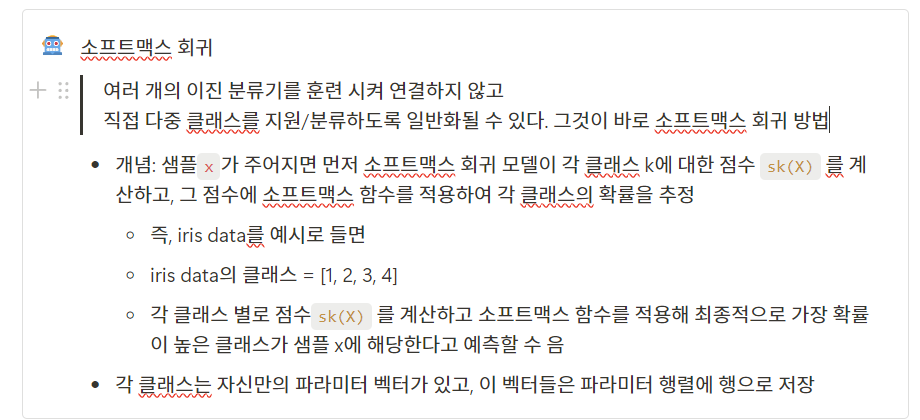

In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

그럼 이렇게 기존의 타깃값이었던 `y` 가 예쁘게 [확률값, 확률값, 확률값] 형태로 바뀐다.

In [ ]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

그럼 동일하게 아까 나누었던 테스트, 검증, 훈련셋에 대해서도 원-핫 인코딩을 쭉 해주면 되겠네

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [ ]:
Y_train_one_hot.shape

(90, 3)

150 중에 90 (=60%) 문제없고

## 2. 소프트맥스 함수 구현
이제 찐으로 x 샘플이 특정 꽃 품종(클래스)에 속할 확률을 계산하기 위해 소프트맥스 점수를 계산해주기만 하면 끝일 듯..? (아마)

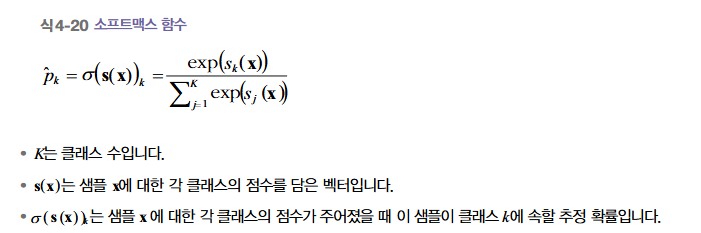




> 책에 나와있는 소프트맥수 함수 그대로 코드화 해준 것 뿐

함수 어떻게 코드화하는지는 구글링 참고했음,,,

외우고 다니면 ㅇㅈ

* `logits`: 모든 샘플에 대한 소프트맥스 점수로 구성된 (m, K) 모양의 어레이.
* `m`은 샘플 수
* 반환값은 `s(X)`

In [ ]:
def softmax(logits):
    exps = np.exp(logits) # 분자
    exp_sums = np.sum(exps, axis=1, keepdims=True) # 분모
    return exps / exp_sums

💡 결론
* 소프트맥스는 입력값을 확률로 변환하는 함수
* `𝑒𝑧`로 큰 값은 더 커지고, 작은 값은 더 작아지게 함.
* 전체 합이 1이 되도록 정규화해서 확률 분포를 생성.
* 클래스 분류 문제에서 가장 가능성 높은 클래스를 선택하는 데 유용

## 3. 모델 훈련



> 앞서 작성한 소프트맥스 함수를 활용해 모델 훈련시켜주고 결과



거의 다 한 듯..?
입력과 출력의 개수를 정의

In [ ]:
n_inputs = X_train.shape[1] # (특성 2개 + 편향 1개 = 3개)
n_outputs = len(np.unique(y_train))   # (3개의 붓꽃 클래스), unique로 3개 뽑아주면 되고~

**배치 경사하강법 적용 과정을 구현하기 위해 비용 함수와 비용 함수의 그레이디언트 벡터 정의**

```
크로스 엔트로피 손실 함수
```

란?
* 모델이 예측한 확률 분포와 실제 정답 분포가 얼마나 다른지를 측정하는 함수!
* 값이 작을수록 모델이 잘 예측하고 있는 것!

In [ ]:
eta = 0.01 # 학습률
n_iterations = 5001 # 에폭
m = len(X_train) # 훈련 데이터 개수
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs) # 가중치 초기화

# 경사 하강법 반복 학습
for iteration in range(n_iterations):
    logits = X_train.dot(Theta) # 훈련 데이터 X_train에 가중치 Theta를 곱해서 클래스별 점수(로짓, logits)를 계산
    Y_proba = softmax(logits) # 이 점수를 아까 위에서 정의했던 소프트맥스 함수로 점수 -> 확률로 변환
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1)) # 크로스 엔트로피 손실 함수 코드화한거임
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot # 예측값-실제값 = 에러
    gradients = 1/m * X_train.T.dot(error) # 경사하강법 적용!, 위 교재 실습에서 했던 구조 그대로 가져옴
    Theta = Theta - eta * gradients # 손실이 줄어드는 방향으로 가중치 업데이트

0 2.639528567767038
500 0.9466849381113658
1000 0.7442054562460835
1500 0.6373461014015417
2000 0.5711703661275321
2500 0.5252883022825786
3000 0.4909740008756654
3500 0.4639304351722579
4000 0.4417971516583559
4500 0.4231647870862234
5000 0.40713573527334457


전체 흐름을 다시 보면:

1️⃣ 초기 가중치(Theta) 설정
2️⃣ 훈련 데이터로 예측값 계산
3️⃣ 손실 함수(크로스 엔트로피) 계산
4️⃣ 오차(Error) 계산
5️⃣ 경사(Gradient) 계산
6️⃣ 가중치 업데이트 (경사 하강법 적용)
7️⃣ 500번마다 손실값 출력
8️⃣ 반복하면서 모델이 점점 최적의 가중치를 찾음

결국 이 과정이 끝나면 최적의 Theta 값을 얻게 되고,
새로운 입력 데이터에 대해 가장 적절한 클래스 예측 확률을 출력할 수 있게 되는 것

> 파라미터 `Theta` (가중치) 확인

* 소프트맥스 회귀(다중 클래스 로지스틱 회귀)에서 Theta 행렬은 각 클래스별로 학습된 가중치(weight)들을 의미!!
* 즉, 모델이 입력 데이터[꽃잎 길이, 꽃잎 넓이]를 보고 특정 클래스로 분류할 확률을 예측할 때 사용하는 **계수(가중치)**들

In [ ]:
Theta

# 각 클래스의 가중치를 담은 행렬

array([[ 2.29682691, -1.56851456, -2.93164073],
       [ 0.44833187,  1.42718525,  0.42934737],
       [-1.67739743,  0.01161009,  3.92539063]])

* 행 개수(3개) → 3개의 클래스(붓꽃의 세 가지 품종)
* 열 개수(3개) → 2개의 특성(꽃잎 길이, 꽃잎 넓이) + 1개의 편향(bias)
> 즉, 각 행이 "내가 이 클래스에 속할 가능성이 얼마나 되는지"를 계산하는 식을 제공하는 것

검증 세트 체크

In [ ]:
logits = X_valid.dot(Theta) # 검증 세트 (X_valid)에 대해서 적용
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

## 4. 이제 조기종료만 추가해주면 되겠네..에효

> 사이킷런에서는 '딸칵'으로 되지만 직접 연습해보는 과정에서 개념 이해

근데 머리가 너무 아파서 GPT 도움 좀...

In [ ]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

0 5.999626000187875
500 0.56576233101253
1000 0.5359643293647358
1500 0.5270671955675367
2000 0.5236387857931382
2500 0.5221837022869387
3000 0.5215293137339516
3500 0.5212216425858525
4000 0.5210710150554994
4500 0.5209942237138998
5000 0.5209534096940153


In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

검증은 여기까지, 이제 찐 테스트셋에 대해 최종 성능을 확인

In [ ]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9666666666666667